In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    #!git clone https://github.com/mjwock/DeepFLaSH_Pytorch.git /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI/
    %cd /content/drive/My\ Drive/DeepFLaSH_Pytorch/FastAI2
    #!git pull
except:
    pass

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2


In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

!pip install elasticdeform

import os
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

from torch import nn
from torchsummary import summary
from sklearn.model_selection import StratifiedKFold, KFold

from datetime import datetime
from ipywidgets import widgets

from deepflash import preproc, unetadaption, utility
from deepflash.fastai_extension import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Using TensorFlow backend.


## Settings

Load a previous model ('yymmdd-HHMM' format) or set to None

In [0]:
LOAD_MODEL = None
STAGE = None        # execute stage 0,1,2

General Params

In [0]:
DIR = '/content/drive/My Drive/DeepFLaSH_Pytorch/FastAI2/data'

IMAGE_COLOR = 'red'   # 'red','green'

IMAGE_TYPE = 'L'    # 'L' for greyscale, 'RGB'for color, 'P' for palette images

TILE_SHAPE = (540,540)    # desired input size
MASK_SHAPE = (356,356)       # 540-184
EL_SIZE = [635.9, 635.9]

SEED = 42

In [0]:
# ONLY CHANGE FOR DIFFERENT FOLDER STRUCTURE
IMG_PATH = f'{DIR}/images/{IMAGE_COLOR}'
MASK_PATH = f'{DIR}/temp_data/labels/'
WEIGHT_PATH = f'{DIR}/temp_data/weights/'

# DON'T CHANGE
PADDING = tuple(np.subtract(TILE_SHAPE,MASK_SHAPE))

Training Params

In [0]:
BATCH_SIZE = 7
N_SPLITS = 10
WEIGHT_DECAY = 0.01
INITIAL_KFOLD = False   # trials show that an initial k-fold does not seem to be necessary

Network Params

In [0]:
IN_CHANNELS = 1 #dependant on IMAGE_TYPE : 1 if 'L' or 'P', 3 if 'RGB'
N_CLASSES = 2  #number of classes
DEPTH = 5
BATCH_NORM = True #batch normalization after first layer

In [0]:
def split_net(model):
  return list(model.children())

# Custom Net Overview

In [0]:
#GPU Hardware Acceleration needed (cuda)

net = unetadaption.UNet(in_channels=IN_CHANNELS,
                        n_classes=N_CLASSES,
                        depth=DEPTH,
                        batch_norm=BATCH_NORM)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = net.to(device)

summary(model, input_size=(IN_CHANNELS, TILE_SHAPE[0], TILE_SHAPE[1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 538, 538]             640
              ReLU-2         [-1, 64, 538, 538]               0
            Conv2d-3         [-1, 64, 536, 536]          36,928
              ReLU-4         [-1, 64, 536, 536]               0
     UNetConvBlock-5         [-1, 64, 536, 536]               0
            Conv2d-6        [-1, 128, 266, 266]          73,856
              ReLU-7        [-1, 128, 266, 266]               0
       BatchNorm2d-8        [-1, 128, 266, 266]             256
            Conv2d-9        [-1, 128, 264, 264]         147,584
             ReLU-10        [-1, 128, 264, 264]               0
      BatchNorm2d-11        [-1, 128, 264, 264]             256
    UNetConvBlock-12        [-1, 128, 264, 264]               0
           Conv2d-13        [-1, 256, 130, 130]         295,168
             ReLU-14        [-1, 256, 1

## Load Data

Retrieve images from folder

In [0]:
filenames = os.listdir(IMG_PATH)

img_ids = [os.path.splitext(files)[0] for files in filenames] # get list with img_ids
imgExt = os.path.splitext(filenames[0])[1]                    # get image extension

In [0]:
images = [img_name for img_name in [f'{s}{imgExt}' for s in img_ids]]
img_df = pd.DataFrame([Path(image) for image in images])

Function to map from image path to mask and weight paths

In [0]:
### Change regDigits if filenames have a different structure

regDigits = '\d{4}'
maskExt = '.tif'
get_labels = lambda x: Path(f'{MASK_PATH}/{re.findall(regDigits,Path(x).stem)[0]}{maskExt}')
get_weights = lambda x: Path(f'{WEIGHT_PATH}/{re.findall(regDigits,Path(x).stem)[0]}{maskExt}')

Show example image, labels and weights

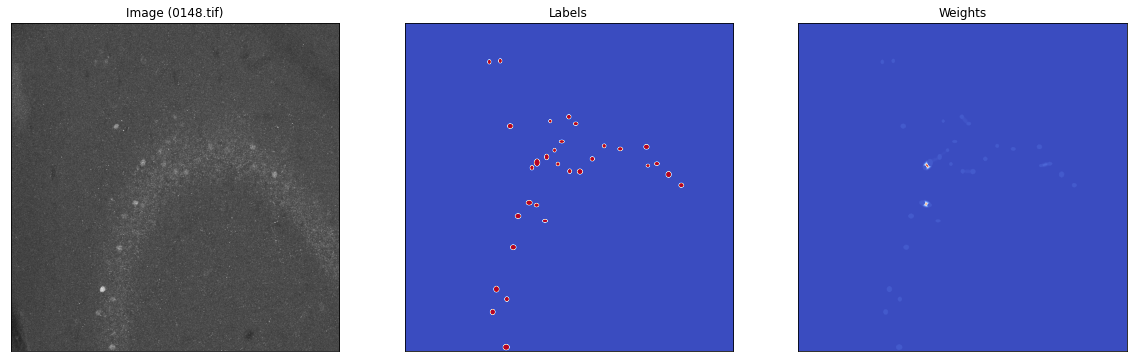

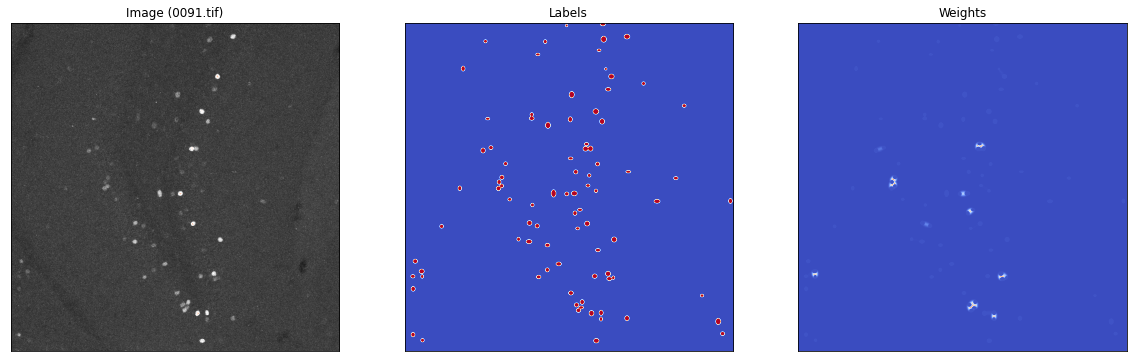

In [0]:
# cmap can be either string or list of strings
utility.show_example_data_batch(IMG_PATH,img_df,get_labels,get_weights,cmap=('RdGy_r','coolwarm','coolwarm'), n=2)

# Data Preparation

**Data Augmentation** <br>SETTINGS<br>Change augmentation params here

In [0]:
DEFORMATION = True    #elastic deformation with magnitude SIGMA and number ob gridpoints GRID_DIVS
SIGMA = 6
GRID_DIVS = 8

RAND_CROP = True    #random crop of image?

ROTATION_MAX_ANGLE = 10     #max rotation in degrees

LIGHT_CONTRAST_CHANGE = 0.01    #max increase of brightness/contrast

TRANSFORM_VALID = True    #also transform validation dataset

xtra_tfms = None  #add extra transforms as list here, e.g. xtra_tfms = [jitter()]

Calculate the range of center coordinates for random crop

In [0]:
# gets original size of raw images
original_size = utility.get_image_size(f'{IMG_PATH}/{img_ids[0]}{imgExt}')

# min distance from any border of the image in percent (tuple for x and y):
row_col_per = np.divide(np.add(np.multiply(0.5,TILE_SHAPE),1),original_size)

# ranges for row_pct and col_pct for initial_crop_pad(**rand_pos):
rand_pos = {'row_pct':(row_col_per[0],1-row_col_per[0]), 'col_pct':(row_col_per[1],1-row_col_per[1])}

Visualization of deformation grid

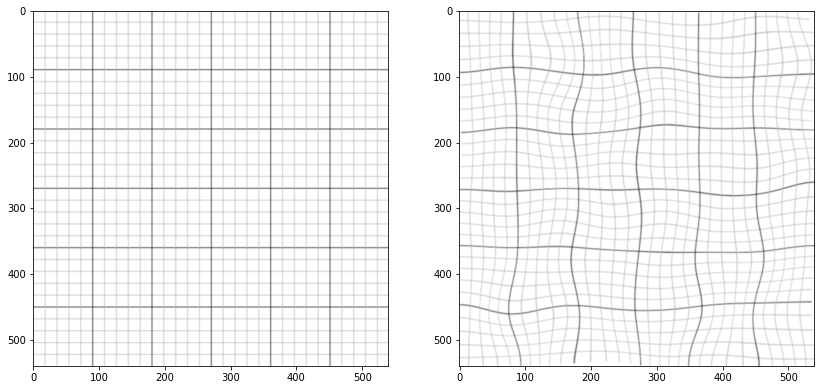

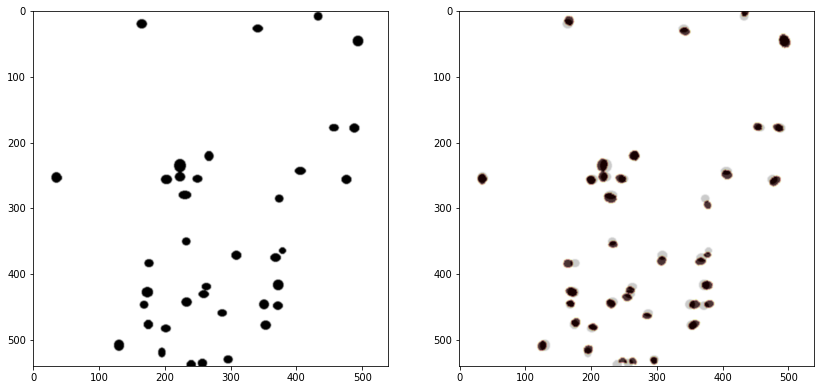

In [0]:
example_img = io.imread(get_labels(img_ids[2]))

utility.test_deformation(shape=TILE_SHAPE,sigma=SIGMA,points=GRID_DIVS)
utility.test_deformation(shape=TILE_SHAPE,example_img=example_img, sigma=SIGMA,points=GRID_DIVS)

**Custom 'get_transforms()' function for selected augmentations**

Transforms are generally applied on train set only, but this can be changed with 'transform_valid_ds = True'. Standard transforms on train set include: 

*   randomly mirror image on x- and y-axis
*   light brightness and contrast shift
*   random rotation
*   elastic deformation





In [0]:
tfms = get_custom_transforms(elastic_deformation= DEFORMATION,
                             elastic_deform_args= {'sigma':SIGMA, 'points':GRID_DIVS},
                             random_crop= TILE_SHAPE if RAND_CROP else None,
                             rand_pos= rand_pos, 
                             max_lighting= LIGHT_CONTRAST_CHANGE,
                             max_rotate= ROTATION_MAX_ANGLE,
                             transform_valid_ds= TRANSFORM_VALID,
                             xtra_tfms = xtra_tfms
                             )

**Create databunch object**

In [0]:
data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode=IMAGE_TYPE)
      # import from df in grayscale
      .split_by_rand_pct(valid_pct=(1/N_SPLITS))
      # 1/10 random train/validation split
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
      # segmentation labels and weights
      .transform(tfms=tfms, tfm_y=True)
      # apply data augmentation
      .databunch(bs=BATCH_SIZE)
      # set batchsize
)

Masks will be cropped to (356, 356). Choose 'None' to keep initial size.
Masks will be cropped to (356, 356). Choose 'None' to keep initial size.


In [0]:
data.show_batch()

Output hidden; open in https://colab.research.google.com to view.

## Learner object and Training

Metrics

In [0]:
# metrics_wrapper let's you use any metric for this weighted-labels architecture 
# (get's rid of the weights and passes only labels to metric)
# if 'swap_preds = True' prediction and groundtruth are swapped (useful for sklearn.metrics)
# if 'softmax = True' all predictions will be normalized using nn.Softmax2d

IoU = metrics_wrapper(metric=dice, iou=True)
f1 = metrics_wrapper(metric=fbeta, beta=1) ##Ignore class 0, argmax result of softmax or round
foreground = metrics_wrapper(metric=foreground_acc, void_code=0)

metrics = [IoU,f1,foreground]

Learner

In [0]:
# set foldername for this training as today's date in yyddmm-hhmm-format
run_folder = datetime.today().strftime('%y%d%m-%H%M')

if LOAD_MODEL:
  run_folder = LOAD_MODEL

In [0]:
run_folder ='201903-0954'

In [0]:
def initiate_learner(folder):
  learn = Learner(data, 
                  net,
                  model_dir = f'{DIR}/model/{folder}',
                  opt_func = torch.optim.Adam,
                  metrics = metrics,
                  loss_func = WeightedCrossEntropyLoss(axis=1, reduction_mode='mean'),
                  callback_fns = ShowGraph,
                  wd = WEIGHT_DECAY)
  return learn

In [0]:
learn = initiate_learner(run_folder)

Learning Rate Finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


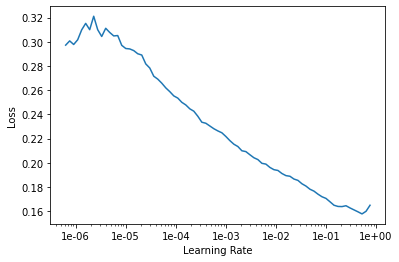

In [0]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [0]:
MAX_LEARNING_RATE = utility.chose_lr()

# for initial training, a higher number of epochs can be used (>30)
INITIAL_EPOCHS = utility.chose_n_epochs()

Chose learning rate (e.g. 1e-04): 
2e-03
Number of training epochs: 
35


**Initial Training Cycle**

In [0]:
#save initiation weights
learn.save('initiation_stage')

In [0]:
# initiate kfold
kfold = KFold(N_SPLITS, True, SEED)

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.243503,0.283053,0.000000,0.040651,0.000000,00:12
1,0.206144,0.332732,0.000000,0.051151,0.000000,00:13
2,0.191609,0.346472,0.009420,0.040315,0.012874,00:11
3,0.178045,0.306530,0.032257,0.043531,0.752034,00:12
4,0.168138,0.293451,0.001171,0.037306,0.002444,00:11
5,0.164618,0.430611,0.030907,0.041209,1.000000,00:12
6,0.159060,0.672530,0.024989,0.033319,1.000000,00:13
7,0.154048,1.715086,0.035723,0.047630,1.000000,00:14
8,0.149348,0.751618,0.028482,0.037976,1.000000,00:12
9,0.144148,0.366090,0.030153,0.036527,0.997696,00:13


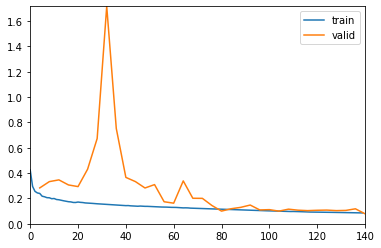

In [0]:
# if kfold for first run
if INITIAL_KFOLD:

  count = 0
  for train, test in kfold.split(img_df):
    
    #load initiation weights
    utility.blockPrint()
    learn = initiate_learner(run_folder)
    learn.load(f'initiation_stage')

    #load data for this fold
    data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode=IMAGE_TYPE)
        .split_by_idxs(train_idx=train, valid_idx=test)
        .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
        .transform(tfms=tfms, tfm_y=True)
        .databunch(bs=BATCH_SIZE)
    )
    utility.enablePrint()

    #change train and valid data
    learn.data = data

    learn.fit_one_cycle(INITIAL_EPOCHS,max_lr=MAX_LEARNING_RATE)
    
    # save results of fold
    learn.save(f'initial_stage-{count}')
    learn.purge()
    learn.destroy()

    count += 1

else:
  learn.load('initiation_stage')

  learn.fit_one_cycle(INITIAL_EPOCHS,max_lr=MAX_LEARNING_RATE)

  learn.save('initial_stage-best_fold')

**Second Training Cycle with KFold**

CHOSE best fold if initial training with kfold

In [0]:
# if there was an initial kfold, load best fold
if INITIAL_KFOLD:
  
  BEST_FOLD = utility.chose_fold()
  stage_name = f'initial_stage-{BEST_FOLD}'

  learn = initiate_learner(run_folder)
  learn.load(stage_name)

  learn.save('initial_stage-best_fold')

#otherwise load single fold
else:
  stage_name = 'initial_stage-best_fold'
  learn.load(stage_name)

utility.blockPrint()
learn.load(stage_name)
utility.enablePrint()

Learning Rate Finder

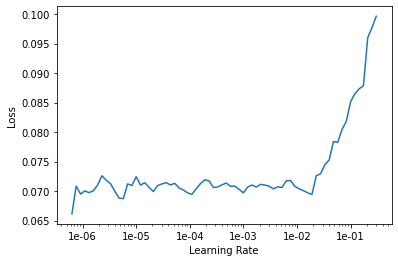

In [0]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [0]:
# CHOSE best learning rate and number of training epochs
LEARNING_RATE = utility.chose_lr()
TRAIN_EPOCHS = utility.chose_n_epochs() # usually around 10-15

Chose learning rate (e.g. 1e-04): 
4e-06
Number of training epochs: 
6


Train

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.076082,0.084973,0.406132,0.037661,0.494518,00:15
1,0.074499,0.070641,0.390435,0.028140,0.527152,00:11
2,0.073625,0.087375,0.417118,0.040675,0.523634,00:11
3,0.072785,0.085442,0.403547,0.040654,0.538591,00:13
4,0.072031,0.076659,0.397425,0.037695,0.514443,00:11
5,0.073484,0.081468,0.419637,0.040730,0.545977,00:11


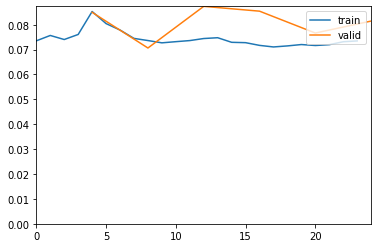

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.080763,0.067265,0.498633,0.042156,0.594647,00:11
1,0.081223,0.080287,0.524140,0.054005,0.632153,00:12
2,0.078305,0.075480,0.486103,0.043939,0.619179,00:13
3,0.078633,0.085664,0.501043,0.055533,0.594392,00:12
4,0.077651,0.071884,0.468949,0.042635,0.596854,00:13
5,0.076663,0.069856,0.472015,0.039518,0.599468,00:10


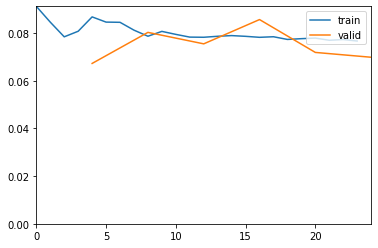

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.077185,0.050680,0.472006,0.025449,0.727573,00:11
1,0.077805,0.051105,0.457928,0.025670,0.709836,00:13
2,0.077650,0.053236,0.486803,0.029665,0.729054,00:12
3,0.077231,0.050787,0.483054,0.028658,0.748899,00:12
4,0.076627,0.049814,0.482629,0.027787,0.735163,00:13
5,0.076889,0.049854,0.474730,0.025489,0.729440,00:13


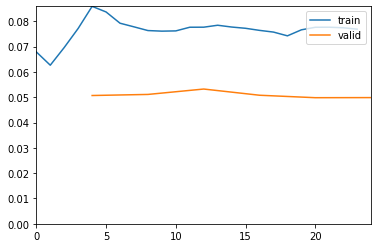

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.072355,0.085149,0.360078,0.041206,0.478841,00:13
1,0.074204,0.099461,0.370890,0.050933,0.475032,00:12
2,0.072348,0.103605,0.337023,0.051653,0.479811,00:12
3,0.069772,0.100353,0.268318,0.048345,0.450846,00:13
4,0.068930,0.104261,0.384325,0.054738,0.498078,00:14
5,0.068721,0.095831,0.312278,0.045959,0.435733,00:10


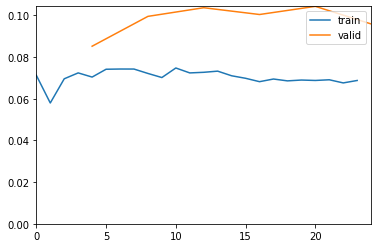

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.073616,0.055684,0.319857,0.022354,0.582421,00:13
1,0.075793,0.063810,0.359272,0.031725,0.605372,00:13
2,0.077708,0.089696,0.342378,0.058634,0.574934,00:13
3,0.075742,0.082554,0.321581,0.048744,0.566719,00:13
4,0.075707,0.058639,0.291945,0.022233,0.589731,00:11
5,0.075662,0.059875,0.350289,0.026917,0.606019,00:12


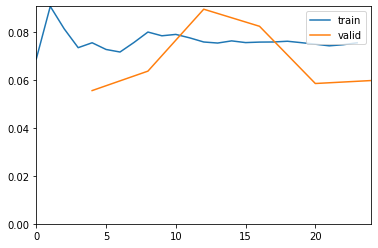

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.077156,0.048023,0.439395,0.026685,0.677607,00:12
1,0.075548,0.046127,0.447114,0.027758,0.693292,00:11
2,0.077596,0.041094,0.473832,0.023503,0.699082,00:11
3,0.075686,0.042545,0.453512,0.026307,0.728754,00:12
4,0.076125,0.043903,0.458957,0.026109,0.698902,00:13
5,0.075880,0.045748,0.430742,0.026246,0.679327,00:12


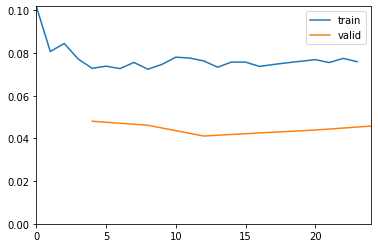

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.071144,0.044233,0.506492,0.031088,0.809250,00:12
1,0.074010,0.047529,0.481943,0.031358,0.783941,00:12
2,0.074191,0.051413,0.531809,0.040981,0.781191,00:11
3,0.073674,0.048671,0.488126,0.032473,0.810583,00:15
4,0.073372,0.052806,0.518281,0.038758,0.749638,00:12
5,0.073504,0.046451,0.548311,0.033704,0.774633,00:12


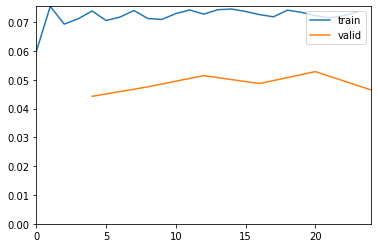

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.062360,0.119174,0.393333,0.063751,0.497607,00:12
1,0.068576,0.123330,0.397100,0.069362,0.474089,00:11
2,0.068364,0.118972,0.386255,0.067146,0.467906,00:11
3,0.069773,0.111913,0.384313,0.062717,0.488985,00:12
4,0.069312,0.123694,0.389841,0.068829,0.493300,00:12
5,0.070050,0.108102,0.398486,0.061300,0.499085,00:11


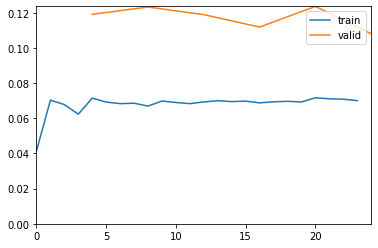

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.070692,0.078820,0.493333,0.049373,0.592088,00:13
1,0.066424,0.085850,0.496501,0.052200,0.579845,00:12
2,0.068265,0.077553,0.530977,0.051512,0.658860,00:12
3,0.070155,0.074578,0.524951,0.041637,0.608945,00:12
4,0.071815,0.079883,0.552337,0.050653,0.635973,00:13
5,0.073167,0.082698,0.523388,0.048857,0.608814,00:11


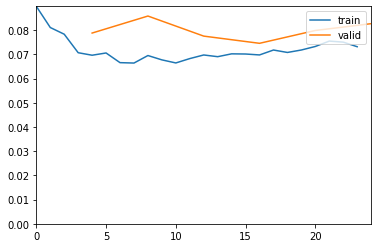

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.087805,0.082112,0.400911,0.043271,0.503688,00:13
1,0.079946,0.080822,0.372412,0.042384,0.487589,00:12
2,0.078061,0.072811,0.387191,0.039750,0.509396,00:12
3,0.077172,0.082261,0.402933,0.043720,0.518890,00:11
4,0.075551,0.079323,0.362237,0.040641,0.516524,00:10
5,0.074288,0.070421,0.424458,0.038060,0.561688,00:11


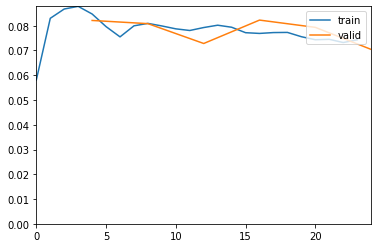

In [0]:
count = 0

# enumerate splits
for train, test in kfold.split(img_df):
  
  utility.blockPrint()
  learn = initiate_learner(run_folder)
  learn.load(stage_name)

  # set name of fold
  fold_name = f'stage1-kfold-{count}'

  #load data for this fold
  data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode=IMAGE_TYPE)
      .split_by_idxs(train_idx=train, valid_idx=test)
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
      .transform(tfms=tfms, tfm_y=True)
      .databunch(bs=BATCH_SIZE)
  )
  utility.enablePrint()

  # swap data of Leaner
  learn.data = data

  # train
  learn.fit_one_cycle(TRAIN_EPOCHS,wd=WEIGHT_DECAY, max_lr = LEARNING_RATE)

  # save and destroy learner
  learn.save(fold_name)
  learn.purge()
  learn.destroy()

  count += 1  

**Third Training Cycle with Freeze**

CHOSE best fold from Second Training Cycle

In [0]:
BEST_FOLD = utility.chose_fold()

Index of fold to use for further training (0,...,n): 
8


In [0]:
utility.blockPrint()

# initiate learner
learn = initiate_learner(run_folder)

# either load a best fold or save current best fold
if LOAD_MODEL and STAGE == 2:
  stage_name = 'stage1-best_fold'
  learn.load(stage_name)

else:
  stage_name = f'stage1-kfold-{BEST_FOLD}'
  learn.load(stage_name)
  learn.save('stage1-best_fold')

learn.split(split_net)

utility.enablePrint()

In [0]:
learn.freeze()
#learn.summary()

UNet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 538, 538]       640        False     
______________________________________________________________________
ReLU                 [64, 538, 538]       0          False     
______________________________________________________________________
Conv2d               [64, 536, 536]       36,928     False     
______________________________________________________________________
ReLU                 [64, 536, 536]       0          False     
______________________________________________________________________
Conv2d               [128, 266, 266]      73,856     False     
______________________________________________________________________
ReLU                 [128, 266, 266]      0          False     
______________________________________________________________________
BatchNorm2d          [128, 266, 266]      256        True      
_________________________________________________________

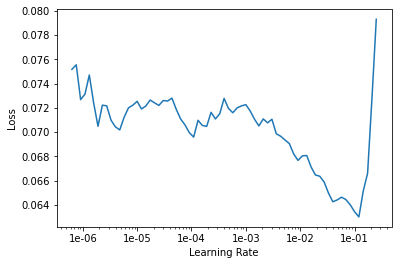

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
# CHOSE best learning rate and number of training epochs
LEARNING_RATE = utility.chose_lr()
TRAIN_EPOCHS = utility.chose_n_epochs() # usually around 10-15

Chose learning rate (e.g. 1e-04): 
2e-02
Number of training epochs: 
15


epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.066731,0.070601,0.389082,0.031041,0.502457,00:10
1,0.064171,0.076026,0.414565,0.036848,0.468951,00:11
2,0.063216,0.059748,0.445254,0.036614,0.560664,00:10
3,0.060058,0.048845,0.383611,0.028984,0.444192,00:10
4,0.057642,0.063483,0.418094,0.036312,0.434811,00:09
5,0.056439,0.059802,0.461776,0.039954,0.534724,00:12
6,0.055111,0.056848,0.412006,0.033663,0.414642,00:11
7,0.054906,0.054732,0.444289,0.034699,0.543167,00:11
8,0.054447,0.060102,0.449239,0.035594,0.494199,00:10
9,0.053241,0.058987,0.496472,0.041882,0.478586,00:11


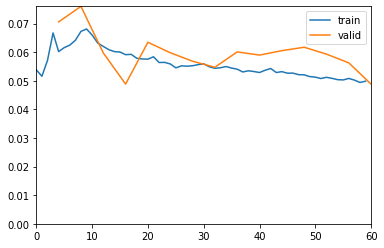

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.066216,0.072149,0.466870,0.048368,0.578575,00:11
1,0.070504,0.056740,0.511076,0.037048,0.585262,00:10
2,0.068942,0.047435,0.520768,0.039305,0.554604,00:11
3,0.066093,0.054034,0.539138,0.046880,0.550045,00:11
4,0.060490,0.051962,0.568106,0.046998,0.588393,00:10
5,0.057816,0.066830,0.536454,0.053773,0.558474,00:12
6,0.056882,0.059867,0.617482,0.056114,0.652261,00:11
7,0.054535,0.050394,0.588597,0.047006,0.653480,00:18
8,0.052756,0.053634,0.587344,0.047535,0.607868,00:10
9,0.051892,0.044320,0.581329,0.044263,0.605027,00:11


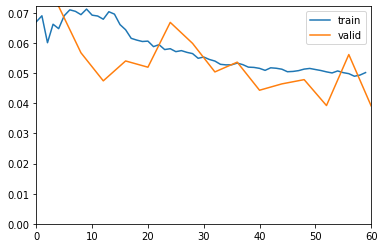

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.067036,0.049145,0.482009,0.026896,0.722668,00:11
1,0.070695,0.043921,0.508733,0.028458,0.717468,00:11
2,0.066987,0.033721,0.533214,0.028584,0.616489,00:11
3,0.063835,0.032520,0.497193,0.026877,0.534299,00:10
4,0.063671,0.027687,0.535799,0.024405,0.614398,00:10
5,0.062010,0.025378,0.563480,0.026244,0.715875,00:12
6,0.061097,0.018095,0.559327,0.019218,0.615300,00:12
7,0.059695,0.027341,0.567691,0.026436,0.713262,00:12
8,0.058010,0.020749,0.552969,0.022546,0.669389,00:11
9,0.056561,0.020577,0.559895,0.023082,0.654284,00:10


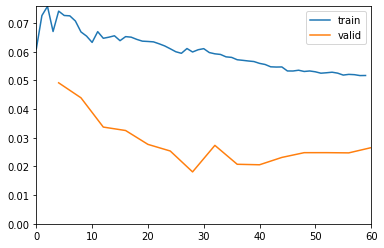

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.070663,0.101456,0.355486,0.055065,0.498472,00:11
1,0.070639,0.072999,0.317557,0.037322,0.429105,00:11
2,0.063479,0.084553,0.377422,0.052750,0.415886,00:10
3,0.058771,0.069125,0.388959,0.041540,0.377042,00:12
4,0.056332,0.074828,0.469614,0.049426,0.504630,00:09
5,0.053513,0.067828,0.418279,0.046656,0.455381,00:11
6,0.052778,0.075154,0.349021,0.047887,0.394848,00:12
7,0.052012,0.072321,0.380260,0.046296,0.458357,00:11
8,0.051171,0.081297,0.390983,0.053694,0.450600,00:10
9,0.050287,0.077721,0.442853,0.053807,0.513100,00:12


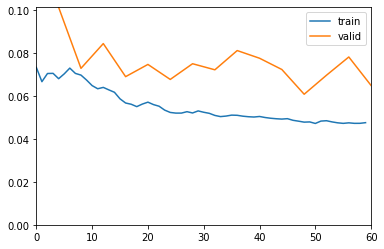

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.075064,0.065665,0.366863,0.038668,0.620596,00:11
1,0.075565,0.078903,0.341349,0.050612,0.539417,00:12
2,0.069822,0.049161,0.332198,0.027753,0.495072,00:09
3,0.063981,0.041314,0.463698,0.029834,0.554968,00:10
4,0.061010,0.052972,0.481179,0.037485,0.589110,00:11
5,0.057916,0.042401,0.604955,0.038269,0.683505,00:08
6,0.056288,0.066196,0.471127,0.057111,0.533527,00:12
7,0.055236,0.038623,0.389133,0.026599,0.545437,00:10
8,0.054741,0.037227,0.447988,0.028682,0.556901,00:10
9,0.054637,0.052444,0.475169,0.044318,0.611276,00:10


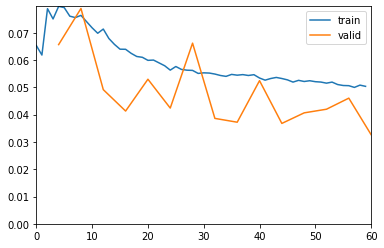

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.082813,0.040055,0.452452,0.025142,0.692646,00:11
1,0.079166,0.029380,0.441075,0.018390,0.692220,00:11
2,0.073106,0.028502,0.457124,0.027093,0.624891,00:12
3,0.069697,0.025557,0.533675,0.027535,0.578756,00:11
4,0.066354,0.024179,0.534045,0.029505,0.669905,00:10
5,0.062728,0.015381,0.488643,0.020373,0.646269,00:11
6,0.061380,0.018752,0.478661,0.023887,0.690156,00:12
7,0.060247,0.025213,0.392614,0.026422,0.575752,00:09
8,0.058527,0.024949,0.460729,0.026864,0.586548,00:10
9,0.056644,0.015034,0.460579,0.022572,0.672104,00:11


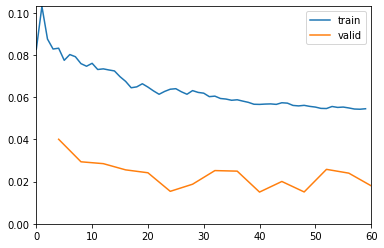

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.078973,0.045477,0.476868,0.033511,0.761406,00:10
1,0.076773,0.042170,0.546839,0.036478,0.720535,00:10
2,0.070859,0.035332,0.561538,0.038411,0.679631,00:11
3,0.067994,0.033686,0.584590,0.041837,0.628416,00:10
4,0.065839,0.028184,0.635487,0.039151,0.683895,00:09
5,0.062678,0.026497,0.601547,0.033578,0.726997,00:09
6,0.061111,0.022827,0.584687,0.032491,0.695197,00:10
7,0.060608,0.027424,0.551593,0.037422,0.724206,00:10
8,0.059346,0.025199,0.599530,0.038386,0.743742,00:10
9,0.057646,0.021065,0.597743,0.030973,0.752831,00:10


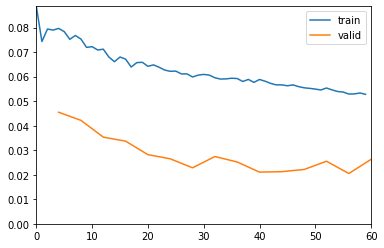

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.067204,0.124915,0.402049,0.070712,0.482196,00:12
1,0.067240,0.115591,0.398882,0.069359,0.443574,00:11
2,0.064570,0.091374,0.343815,0.056022,0.363318,00:09
3,0.061585,0.079623,0.405500,0.052645,0.396283,00:11
4,0.059362,0.091094,0.344671,0.059322,0.349432,00:12
5,0.057825,0.076922,0.459600,0.053771,0.527685,00:11
6,0.056859,0.098965,0.436812,0.061931,0.537146,00:12
7,0.056542,0.106441,0.342845,0.070316,0.364421,00:10
8,0.056097,0.090289,0.367132,0.061731,0.353690,00:09
9,0.054312,0.099062,0.410566,0.065424,0.434230,00:09


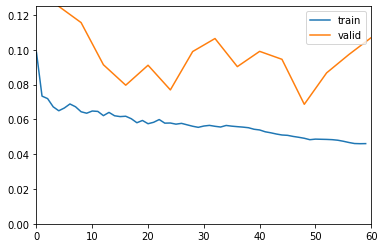

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.067918,0.085304,0.533989,0.051901,0.585203,00:11
1,0.065083,0.072184,0.523132,0.046932,0.542330,00:12
2,0.062388,0.077867,0.557705,0.061009,0.579008,00:09
3,0.060699,0.072709,0.569484,0.060854,0.611825,00:11
4,0.058295,0.064098,0.607989,0.052224,0.631547,00:11
5,0.055145,0.053680,0.608004,0.046220,0.636115,00:11
6,0.053377,0.056947,0.589339,0.044663,0.640154,00:11
7,0.053164,0.063832,0.563753,0.063667,0.592234,00:11
8,0.052548,0.069853,0.567105,0.056401,0.561649,00:10
9,0.050579,0.056148,0.518366,0.047679,0.578405,00:10


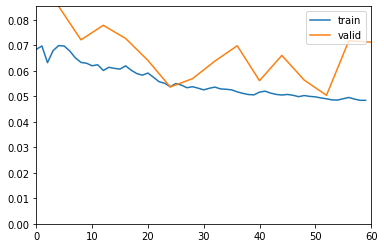

epoch,train_loss,valid_loss,dice,fbeta,foreground_acc,time
0,0.076125,0.079148,0.376564,0.043450,0.489750,00:12
1,0.076973,0.066743,0.392104,0.039175,0.501388,00:10
2,0.072057,0.063556,0.347093,0.039747,0.422005,00:11
3,0.067287,0.068488,0.348614,0.045761,0.358418,00:09
4,0.063981,0.059229,0.407194,0.040055,0.450184,00:12
5,0.060256,0.058009,0.437379,0.040388,0.509074,00:10
6,0.057470,0.065723,0.437903,0.042847,0.518579,00:12
7,0.056584,0.061704,0.430937,0.044818,0.506964,00:12
8,0.054832,0.060417,0.446763,0.042906,0.557009,00:10
9,0.053200,0.053242,0.411775,0.037930,0.471524,00:11


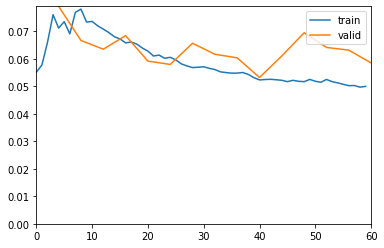

In [0]:
count = 0

# enumerate splits
for train, test in kfold.split(img_df):
  
  utility.blockPrint()
  learn = initiate_learner(run_folder)
  learn.load(stage_name)

  # set name of fold
  fold_name = f'stage2-kfold-{count}'

  #load data for this fold
  data = (CustomSegmentationItemList.from_df(img_df,IMG_PATH, convert_mode=IMAGE_TYPE)
      .split_by_idxs(train_idx=train, valid_idx=test)
      .label_from_funcs(get_labels, get_weights, target_size=MASK_SHAPE, classes = array(['background','cell']))
      .transform(tfms=tfms, tfm_y=True)
      .databunch(bs=BATCH_SIZE)
  )
  utility.enablePrint()

  # swap data of Leaner
  learn.data = data

  # train
  learn.fit_one_cycle(TRAIN_EPOCHS,wd=WEIGHT_DECAY, max_lr = LEARNING_RATE)

  # save and destroy learner
  learn.save(fold_name)
  learn.purge()
  learn.destroy()

  count += 1  

In [0]:
BEST_FOLD = utility.chose_fold()

Index of fold to use for further training (0,...,n): 
1


In [0]:
utility.blockPrint()

# initiate learner
learn = initiate_learner(run_folder)


stage_name = f'stage2-kfold-{BEST_FOLD}'
learn.load(stage_name)
learn.save('final_weights')

utility.enablePrint()

In [0]:
learn.export(f'{DIR}/model/{run_folder}/final_model.pkl')